In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime, pytz

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.metrics import RootMeanSquaredError

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Hyperparameter

In [2]:
SEQ_LEN = 21 # 6, 11, 21
FOLD = 5 # 5, 10
LSTM_Layer = 2 # 1, 2, 3
WINDOW_SIZE = SEQ_LEN - 1

In [3]:
# Google Spreadsheet ID
SHEET_ID = '1JDNv_mArl-GPIpxuWS5GxgVEwvjXocS1MrXGc6TYs8M'
SHEET_NAME = ['USD/IDR', 'EUR/IDR', 'SGD/IDR']

url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME[2]}'
data = pd.read_csv(url)

# Convert Date columns to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y %H:%M:%S')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1959 entries, 0 to 1958
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1959 non-null   datetime64[ns]
 1   Close   1959 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 30.7 KB


## Preprocessing

In [4]:
scaler = MinMaxScaler()
close_price = data.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close.shape

(1959, 1)

In [5]:
def to_sequences(data, seq_len):
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    return np.array(d)

def preprocess(data_raw, seq_len):
    data = to_sequences(data_raw, seq_len)
    target = data[:, -1, :]
    train = data[:, :-1, :]
    return train, target

inputs, targets = preprocess(scaled_close, SEQ_LEN)

tscv = TimeSeriesSplit(n_splits=FOLD)

## Genetic Algorithm

In [6]:
# Genetic Algorithm
def genetic_algorithm(population_size, generations):
    population = np.random.randint(1, high=26, size=(population_size, 3))
    
    for generation in range(generations):
        print(f"Generation - {generation + 1}")
        fitness_scores = np.array([fitness_function(chromosome) for chromosome in population])
        best_chromosome = population[np.argmax(fitness_scores)]
        best_fitness = np.max(fitness_scores)
        
        new_population = []
        
        while len(new_population) < population_size:
            parent1 = selection(population, fitness_scores)
            parent2 = selection(population, fitness_scores)
            offspring_1, offspring_2 = crossover(parent1, parent2)
            mutate(offspring_1)
            mutate(offspring_2)
            new_population.append(offspring_1)
            new_population.append(offspring_2)
        
        population = np.array(new_population)
    
    return best_chromosome, best_fitness

# Selection (Tournament selection)
def selection(population, fitness_scores, tournament_size=3):
    indices = np.random.randint(len(population), size=tournament_size)
    tournament = population[indices]
    tournament_fitness = fitness_scores[indices]
    return tournament[np.argmax(tournament_fitness)]

# Crossover (Single-point crossover)
def crossover(parent1, parent2):
    crossover_point = np.random.randint(1, len(parent1))
    offspring_1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    offspring_2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    return offspring_1, offspring_2

# Mutation (Swap Mutation)
def mutate(chromosome, mutation_rate=0.01):
    for i in range(len(chromosome)):
        if np.random.rand() < mutation_rate:
            j = np.random.randint(len(chromosome))
            chromosome[i], chromosome[j] = chromosome[j], chromosome[i]

# Define the fitness function to be optimized
def fitness_function(chromosome):
    loss = []
    fold_no = 1
    lstm_units = [int(chromosome[i]*10) or default for i, default in enumerate([128, 64, 32])]

    print(f" Population")
    for train, test in tscv.split(inputs, targets):
        print(f"  Fold - {fold_no}", end="")
        
        # Build the LSTM model
        tf.keras.backend.clear_session()
        model = Sequential()
        for i, units in enumerate(lstm_units[:LSTM_Layer]):
            model.add(LSTM(units, return_sequences=(i < LSTM_Layer - 1), input_shape=(WINDOW_SIZE, 1)))
        model.add(Dense(1))

        # Compile and train the model
        model.compile(loss='mean_squared_error',
                      optimizer='adam')
        model.fit(inputs[train],
                  targets[train],
                  epochs=10,
                  batch_size=32,
                  verbose=0,
                  validation_split=0.1)

        # Evaluate the model
        loss.append(model.evaluate(inputs[test], targets[test], verbose=0))
        fold_no += 1
    print()
    
    # Return the negative average value of the loss as the fitness score
    return -np.mean(loss)

In [7]:
import typing
from datetime import datetime

def timer(start_time: datetime = None) -> "typing.Union[datetime.datetime, str]":
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        return "%i hours %i minutes and %s seconds." % (
            thour,
            tmin,
            round(tsec, 2),
        )

In [8]:
# Do not increase this value
population_size = 5
generations = 25

time = timer(None)
best_chromosome, best_fitness = genetic_algorithm(population_size, generations)
time = timer(time)

Generation - 1
 Population
  Fold - 1  Fold - 2  Fold - 3  Fold - 4  Fold - 5
 Population
  Fold - 1  Fold - 2  Fold - 3  Fold - 4  Fold - 5
 Population
  Fold - 1  Fold - 2  Fold - 3  Fold - 4  Fold - 5
 Population
  Fold - 1  Fold - 2  Fold - 3  Fold - 4  Fold - 5
 Population
  Fold - 1  Fold - 2  Fold - 3  Fold - 4  Fold - 5
Generation - 2
 Population
  Fold - 1  Fold - 2  Fold - 3  Fold - 4  Fold - 5
 Population
  Fold - 1  Fold - 2  Fold - 3  Fold - 4  Fold - 5
 Population
  Fold - 1  Fold - 2  Fold - 3  Fold - 4  Fold - 5
 Population
  Fold - 1  Fold - 2  Fold - 3  Fold - 4  Fold - 5
 Population
  Fold - 1  Fold - 2  Fold - 3  Fold - 4  Fold - 5
 Population
  Fold - 1  Fold - 2  Fold - 3  Fold - 4  Fold - 5
Generation - 3
 Population
  Fold - 1  Fold - 2  Fold - 3  Fold - 4  Fold - 5
 Population
  Fold - 1  Fold - 2  Fold - 3  Fold - 4  Fold - 5
 Population
  Fold - 1  Fold - 2  Fold - 3  Fold - 4  Fold - 5
 Population
  Fold - 1  Fold - 2  Fold - 3  Fold - 4  Fold - 5
 Populatio

In [9]:
print("Best Chromosome:", best_chromosome)
print("Best Fitness:", best_fitness)
print("Time Taken:", time)

Best Chromosome: [22 13 13]
Best Fitness: -0.0025397192919626834
Time Taken: 1 hours 32 minutes and 16.83 seconds.


## Re-Training Model with Best Parameter

In [10]:
fold_no = 1
metrics_per_fold = [[] for _ in range(3)]
metrics_inverse_per_fold = [[] for _ in range(3)]
y_test_per_fold, y_hat_inverse_per_fold = [], []
history_per_fold = []

for train, test in tscv.split(inputs, targets):
    tf.keras.backend.clear_session()
    
    model = Sequential()
    for i, units in enumerate(best_chromosome[:LSTM_Layer]):
        model.add(LSTM(units*10, return_sequences=(i < LSTM_Layer - 1), input_shape=(WINDOW_SIZE, 1)))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',
                  metrics=['mae', RootMeanSquaredError()],
                  optimizer='adam')

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history = model.fit(inputs[train],
                        targets[train],
                        epochs=50,
                        batch_size=32,
                        validation_split=0.1,
                        verbose=0)
    
    history_per_fold.append(history)
    
    # Model Evaluation
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    
    # Model Prediction
    y_hat = model.predict(inputs[test])
    y_test_inverse = scaler.inverse_transform(targets[test])
    y_hat_inverse = scaler.inverse_transform(y_hat)
    
    y_test_per_fold.append(y_test_inverse)
    y_hat_inverse_per_fold.append(y_hat_inverse)
    
    # Model Prediction Metrics
    mse_inverse = mean_squared_error(y_test_inverse, y_hat_inverse)
    mae_inverse = mean_absolute_error(y_test_inverse, y_hat_inverse)
    rmse_inverse = np.sqrt(mse_inverse)
       
    mse = mean_squared_error(targets[test], y_hat)
    mae = mean_absolute_error(targets[test], y_hat)
    rmse = np.sqrt(mse)

    print("Model Evaluate (model.evaluate) Result")
    print(f'Score for fold {fold_no}: {model.metrics_names[1]} is {scores[1]}; {model.metrics_names[0]}/mse is {scores[0]}; {model.metrics_names[2]} is {scores[2]}\n')
    
    print("Model Predict (model.predict) Result")
    print(f'Score for fold {fold_no}: mae is {mae}; mse is {mse}; rmse is {rmse}')
    print(f'Score for fold {fold_no}: mae is {mae_inverse}; mse is {mse_inverse}; rmse is {rmse_inverse}\n')

    fold_no += 1
    
    metrics_inverse_per_fold[0].append(mae_inverse) # MAE Inverse
    metrics_inverse_per_fold[1].append(mse_inverse) # MSE Inverse
    metrics_inverse_per_fold[2].append(rmse_inverse) # RMSE Inverse
    
    metrics_per_fold[0].append(mae) # MAE
    metrics_per_fold[1].append(mse) # MSE
    metrics_per_fold[2].append(rmse) # RMSE

------------------------------------------------------------------------
Training for fold 1 ...
11/11 [==============================] - 1s 3ms/step
Model Evaluate (model.evaluate) Result
Score for fold 1: mae is 0.06065521761775017; loss/mse is 0.008274752646684647; root_mean_squared_error is 0.09096566587686539

Model Predict (model.predict) Result
Score for fold 1: mae is 0.06065521212085071; mse is 0.008274753170874819; rmse is 0.09096567028761356
Score for fold 1: mae is 127.88892088332048; mse is 36786.15825683167; rmse is 191.7971800022922

------------------------------------------------------------------------
Training for fold 2 ...
11/11 [==============================] - 1s 4ms/step
Model Evaluate (model.evaluate) Result
Score for fold 2: mae is 0.035024724900722504; loss/mse is 0.0028881875332444906; root_mean_squared_error is 0.05374186113476753

Model Predict (model.predict) Result
Score for fold 2: mae is 0.03502472813519264; mse is 0.0028881873883794137; rmse is 0.053

## Model Evaluation

In [11]:
title = ['MAE', 'MSE', 'RMSE']
for i, unit in enumerate(metrics_per_fold):
    print(f"----------- {title[i]} -----------")
    print(f"Value per Fold : {unit}")
    print(f"Average Training Value : {np.mean(unit)}\n")

----------- MAE -----------
Value per Fold : [0.06065521212085071, 0.03502472813519264, 0.030233658625415313, 0.026615559399229365, 0.052603487737392325]
Average Training Value : 0.04102652920361606

----------- MSE -----------
Value per Fold : [0.008274753170874819, 0.0028881873883794137, 0.0011854870051444053, 0.0008922055449748855, 0.0035684238854383115]
Average Training Value : 0.0033618113989623668

----------- RMSE -----------
Value per Fold : [0.09096567028761356, 0.05374185881023668, 0.03443090189269525, 0.029869809925322347, 0.05973628617045348]
Average Training Value : 0.05374890541726426



In [12]:
for i, unit in enumerate(metrics_inverse_per_fold):
    print(f"----------- {title[i]} -----------")
    print(f"Value per Fold : {unit}")
    print(f"Average Training Value : {np.mean(unit)}\n")

----------- MAE -----------
Value per Fold : [127.88892088332048, 73.84811016157119, 63.74629244872285, 56.11778686145502, 110.91215980553399]
Average Training Value : 86.50265403212072

----------- MSE -----------
Value per Fold : [36786.15825683167, 12839.698213897842, 5270.180687916512, 3966.3834432060594, 15863.746373842012]
Average Training Value : 14945.23339513882

----------- RMSE -----------
Value per Fold : [191.7971800022922, 113.31239214621604, 72.59601013772391, 62.97923025256866, 125.95136511305469]
Average Training Value : 113.3272355303711



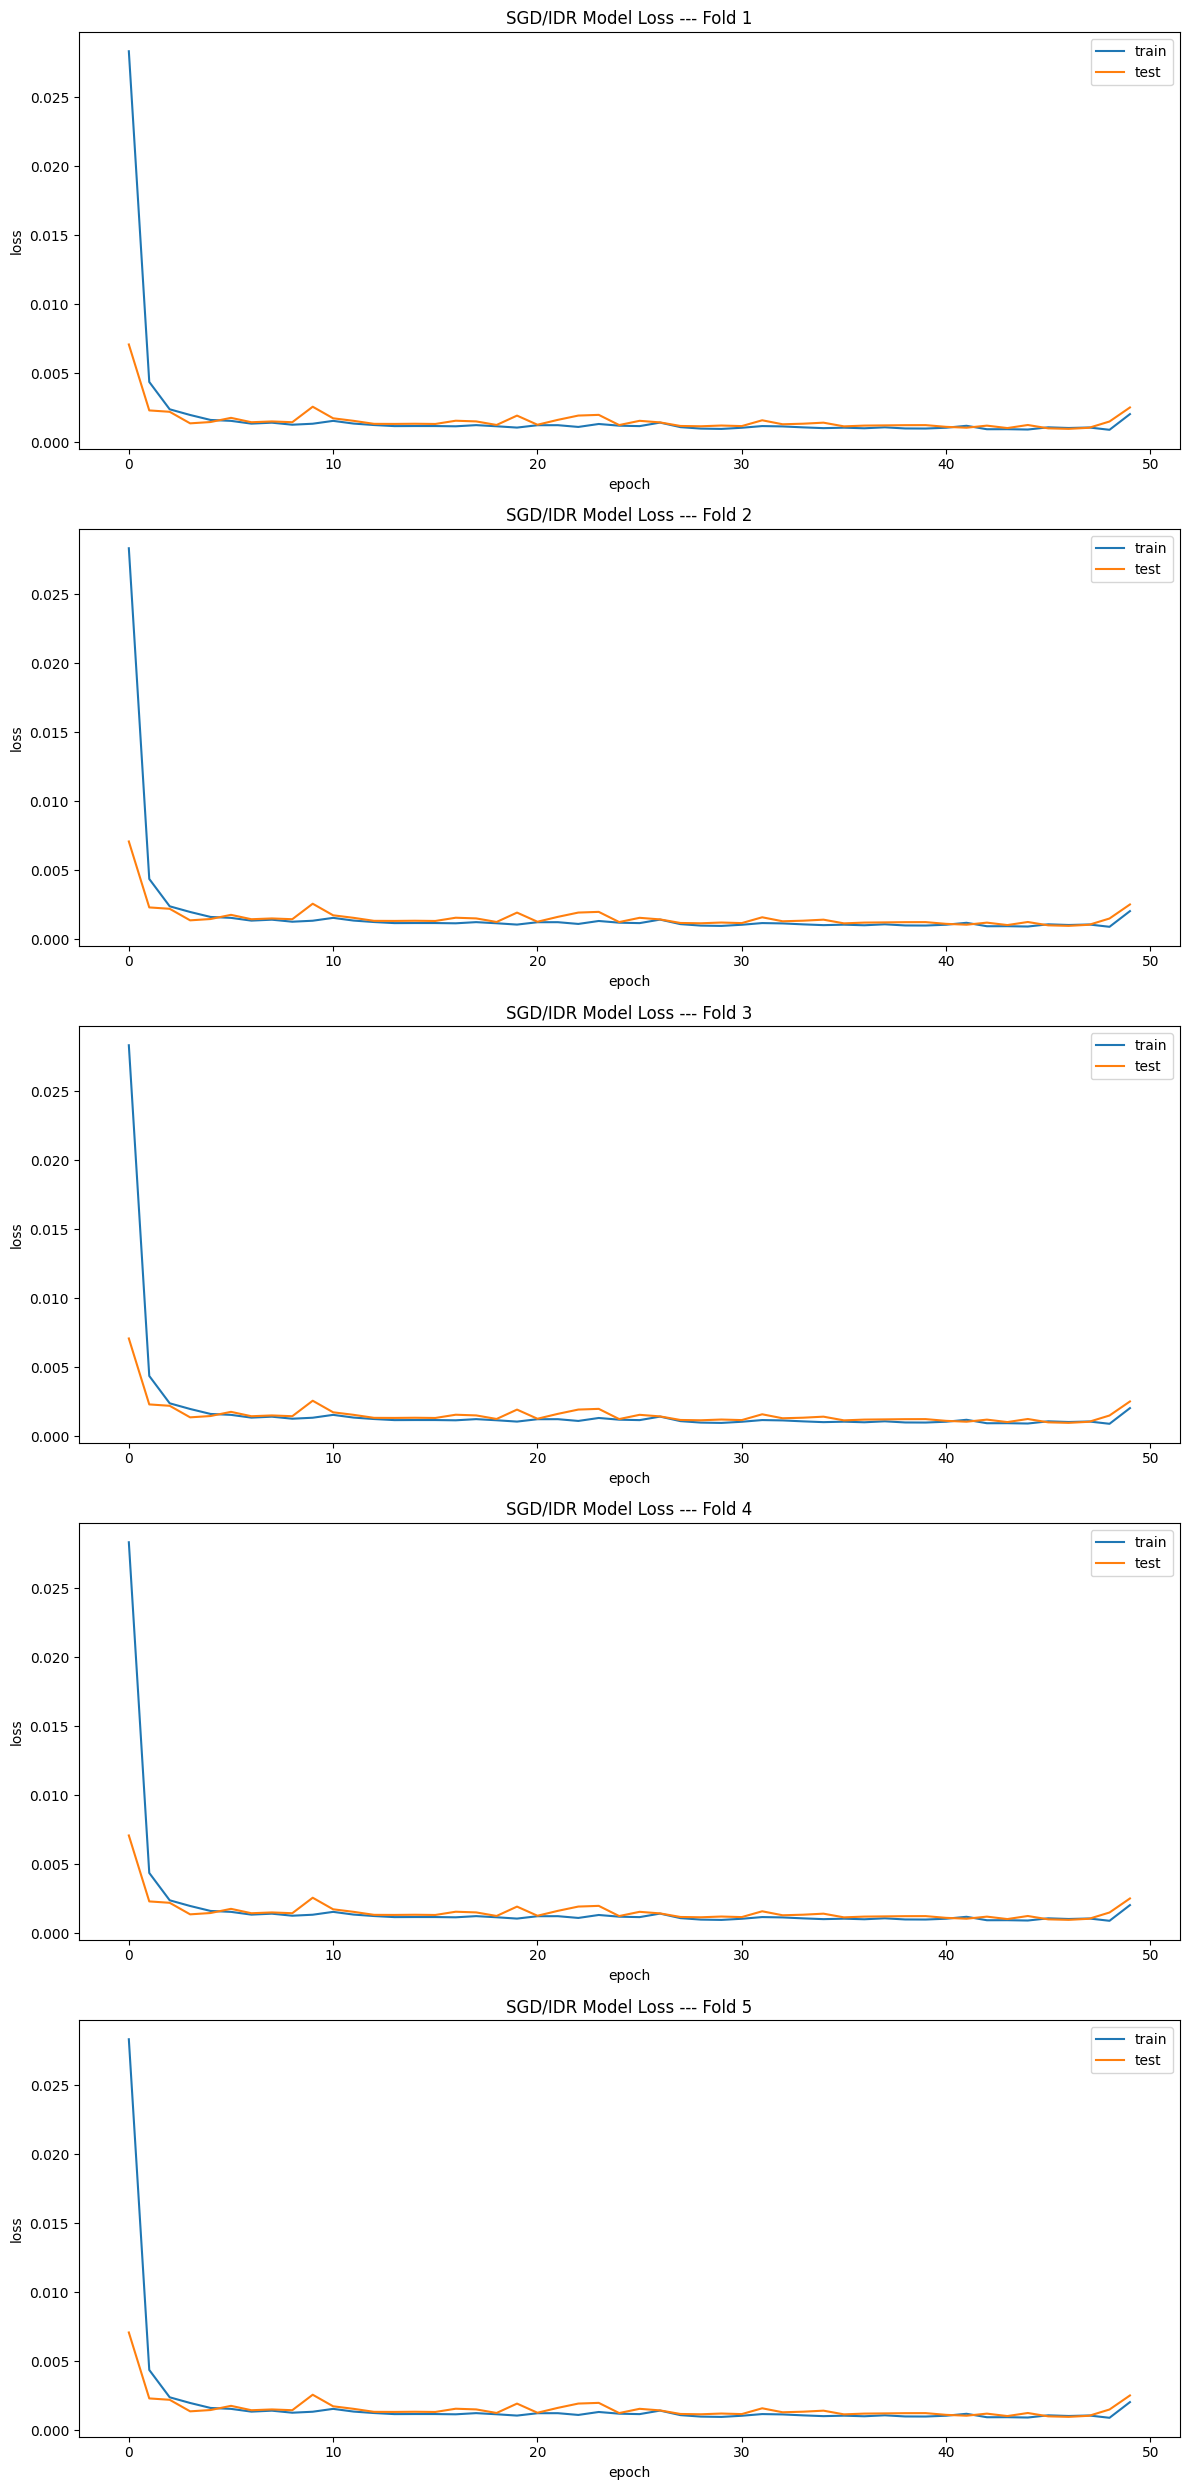

In [13]:
fig, axs = plt.subplots(FOLD, figsize=(12, FOLD*5))
for i in range(FOLD):
    axs[i].plot(history_per_fold[0].history['loss'])
    axs[i].plot(history_per_fold[0].history['val_loss'])

    axs[i].set_title(f'{SHEET_NAME[2]} Model Loss --- Fold {i+1}')
    axs[i].set_xlabel('epoch')
    axs[i].set_ylabel('loss')
    axs[i].legend(['train', 'test'], loc='best')

plt.tight_layout()
plt.show()

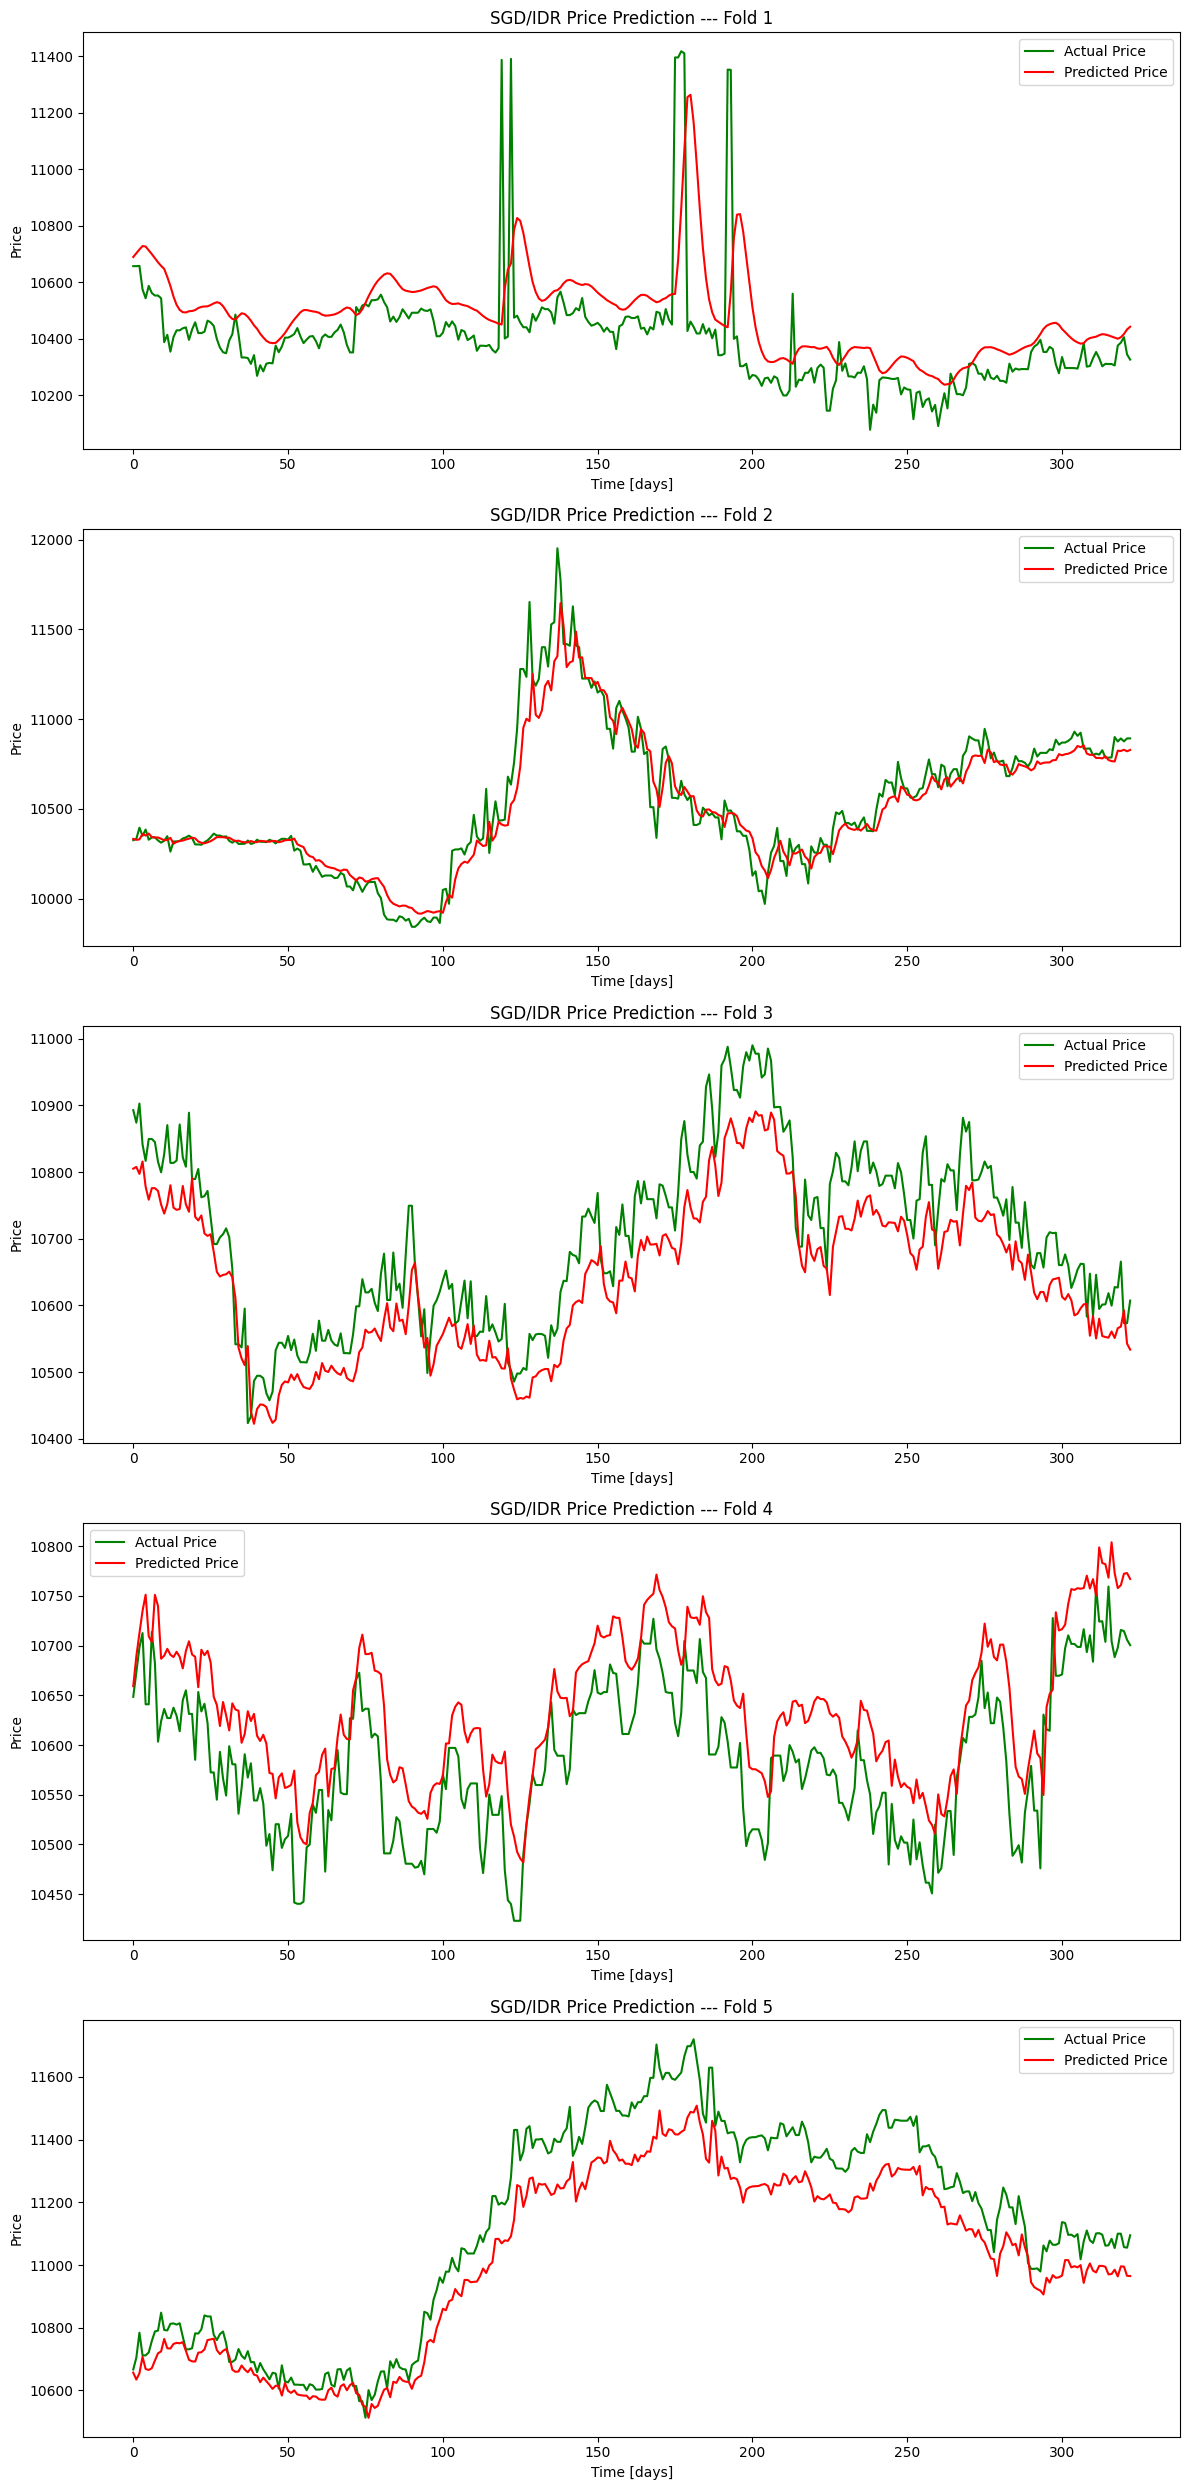

In [14]:
fig, axs = plt.subplots(FOLD, figsize=(12, FOLD*5))
for i in range(FOLD):
    axs[i].plot(y_test_per_fold[i], label="Actual Price", color='green')
    axs[i].plot(y_hat_inverse_per_fold[i], label="Predicted Price", color='red')

    axs[i].set_title(f'{SHEET_NAME[2]} Price Prediction --- Fold {i+1}')
    axs[i].set_xlabel('Time [days]')
    axs[i].set_ylabel('Price')
    axs[i].legend(loc='best')

plt.tight_layout()
plt.show()